# 0. Import Libraries

In [2]:
# Import necessary libraries for data manipulation, visualization, and modeling

import pandas as pd
import pytimetk as tk

import lifetimes as lf
from lifetimes.plotting import plot_probability_alive_matrix

# 1. Import Data

In [4]:
# Load the dataset from a CSV file

orig_df = pd.read_csv('../Datasets/ECommerce_Transactions_CLV.csv')

# Display the first 10 rows to confirm data availability

orig_df.head(10)

CustomerID      OrderID  ProductID          InvoiceDate  Quantity  UnitPrice
0   cust2375  26984851472    1004906  2024-1-03T16:31:00Z         1       1.39
1   cust2375  26984851472    1033142  2024-1-03T16:31:00Z         1       0.82
2   cust2375  26984851472    1036325  2024-1-03T16:31:00Z         1       0.99
3   cust2375  26984851472    1082185  2024-1-03T16:31:00Z         1       1.21
4   cust2375  26984851472    8160430  2024-1-03T16:31:00Z         1       1.50
5   cust2375  26984851516     826249  2024-1-03T16:42:00Z         2       1.98
6   cust2375  26984851516    1043142  2024-1-03T16:42:00Z         1       1.57
7   cust2375  26984851516    1085983  2024-1-03T16:42:00Z         1       2.99
8   cust2375  26984851516    1102651  2024-1-03T16:42:00Z         1       1.89
9   cust2375  26984851516    6423775  2024-1-03T16:42:00Z         1       2.00

# 2. Data Exploration

In [6]:
# Show columns, data types, and nulls to prepare hygiene activities

orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   CustomerID   1048575 non-null  object 
 1   OrderID      1048575 non-null  int64  
 2   ProductID    1048575 non-null  int64  
 3   InvoiceDate  1048575 non-null  object 
 4   Quantity     1048575 non-null  int64  
 5   UnitPrice    1048575 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 48.0+ MB


In [7]:
# Show descriptive statistics for quantitative columns

orig_df.describe()

OrderID     ProductID      Quantity     UnitPrice
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06
mean   2.973557e+10  2.388947e+06  9.442996e+01  3.060295e+00
std    1.332621e+09  3.036772e+06  1.113844e+03  4.015646e+00
min    2.698485e+10  2.567100e+04  0.000000e+00  0.000000e+00
25%    2.860153e+10  9.135980e+05  1.000000e+00  1.290000e+00
50%    2.971283e+10  1.019722e+06  1.000000e+00  2.000000e+00
75%    3.094309e+10  1.120085e+06  1.000000e+00  3.470000e+00
max    3.188413e+10  1.351324e+07  8.505500e+04  5.050000e+02

In [8]:
# Create a copy of the original dataset for manipulation

df = orig_df.copy()

In [9]:
# Convert 'InvoiceDate' to the correct format for time-based analysis

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
# Calculate 'Sales' based on quantity and price of an item within an order

df['Sales'] = df['Quantity']*df['UnitPrice']

In [11]:
df['Sales'].sum()

2979736092.5700006

Sales over the dataset's total time range amount to $2.98  Billion (2,979,736,092.57)

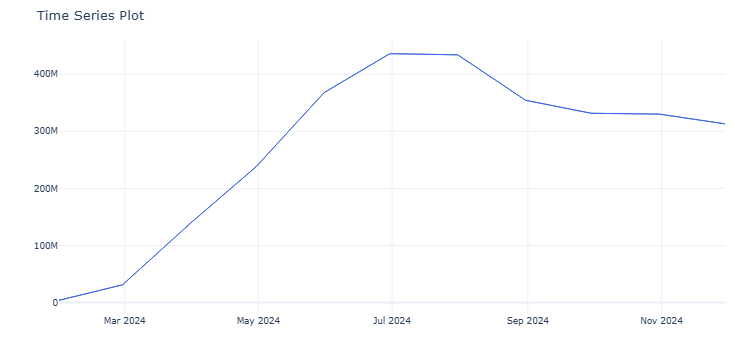

In [13]:
# Visualize 'Sales' over time by 'InvoiceDate'

df[['InvoiceDate', 'Sales']].summarize_by_time(
    date_column = 'InvoiceDate',
    value_column = 'Sales',
    agg_func = 'sum',
    freq = 'M'
).plot_timeseries('InvoiceDate', 'Sales')

# 4. Modeling

## Descriptive Modeling

In [16]:
# Aggregate 'Sales' at the order and customer levels

sales_df = df.groupby(['CustomerID','OrderID']).agg(
    order_sales = ('Sales', 'sum'),
    timestamp = ('InvoiceDate', 'max')
).reset_index().groupby('CustomerID').agg(
    time_days = ('timestamp', lambda x: (x.max() - x.min()).days),
    frequency = ('OrderID', 'nunique'),
    total_Sales = ('order_sales', 'sum'),
    avg_sales = ('order_sales', 'mean')
).reset_index()

In [17]:
print(sales_df)

sales_df.describe()

     CustomerID  time_days  frequency  total_Sales     avg_sales
0         cust1        273         32      2190.63     68.457188
1        cust10         25          6       211.51     35.251667
2       cust100        266          9       890.23     98.914444
3      cust1000        280         53   1123079.71  21190.183208
4      cust1001        309         28      1895.95     67.712500
...         ...        ...        ...          ...           ...
2492    cust995        207         13       779.08     59.929231
2493    cust996        304         46     90063.87   1957.910217
2494    cust997        291         47      2725.22     57.983404
2495    cust998        232         99   1814503.26  18328.315758
2496    cust999        304         32      1979.79     61.868437

[2497 rows x 5 columns]


time_days    frequency   total_Sales     avg_sales
count  2497.000000  2497.000000  2.497000e+03  2.497000e+03
mean    236.396876    45.663997  1.193326e+06  1.989996e+04
std      64.958757    51.263073  3.604947e+06  5.477490e+04
min       0.000000     1.000000  1.660000e+00  1.660000e+00
25%     214.000000    14.000000  6.380200e+02  3.177681e+01
50%     245.000000    31.000000  2.536980e+03  8.154824e+01
75%     280.000000    58.000000  6.937519e+05  1.889281e+04
max     329.000000   547.000000  6.783225e+07  1.255877e+06

In [18]:
# Create a dictionary with key sales metrics

sales_summary = {
    'average_sales': sales_df['avg_sales'].mean(),
    'average_frequency': sales_df['frequency'].mean(),
    'churn_rate': 1 - (sales_df['frequency'] > 5).sum() / len(sales_df['frequency']),
    'max_days': sales_df['time_days'].max()
}

In [19]:
print(sales_summary)

{'average_sales': 19899.964723391044, 'average_frequency': 45.66399679615539, 'churn_rate': 0.07488986784140972, 'max_days': 329}


Within the 328-day time period of the dataset, the average purchase amount per customer equals $19,899.96. On average, customers made 45 purchases within the 328-day time period. The churn rate, or percent of customers that are no longer active, is only 7.49%.

These data points provide helpful baseline numbers for comparison at the cohort level. 

In [21]:
# Define constants

profit_margin = 0.18
customer_lifetime = 3
eps_churn_rate = 0.001

In [22]:
# Estimate Customer Lifetime Value (CLV) using the churn-based method

sales_summary['clv_churn_method'] = (sales_summary['average_sales'] * sales_summary['average_frequency'] / (sales_summary['churn_rate'] + eps_churn_rate)) * profit_margin

In [23]:
print(sales_summary['clv_churn_method'])

2155335.7677321485


The churn-based CLV method values the average customer at $546,058.29. This remarkably high value suggests that customers are expected to be long-term, high-value buyers. 

In [25]:
# Estimate Customer Lifetime Value (CLV) using the lifetime method

sales_summary['clv_lifetime_method'] = (sales_summary['average_sales'] * sales_summary['average_frequency'] / (sales_summary['max_days'] / 365) * customer_lifetime) * profit_margin

In [26]:
print(sales_summary['clv_lifetime_method'])

544398.5425256123


The lifetime CLV method values the average customer at $546,058.29$ This remarkably high value suggests that customers are expected to be long-term buyers with frequent orders, validated by our near $20,000 average order.

In [28]:
# Create a column to represent the first purchase month for each 'CustomerID'

df['start_month'] = df.groupby('CustomerID')['InvoiceDate'].transform(lambda x: x.min().strftime('%Y-%m'))

In [29]:
# Create cohort-based sales data, tracking customer behavior over time

cohort_data = (df.groupby(['start_month', 'CustomerID', 'OrderID']).agg(
    order_sales = ('Sales', 'sum'),
    timestamp = ('InvoiceDate', 'max')
)
    .reset_index()
    .groupby(['start_month', 'CustomerID'])
    .agg(
        time_days = ('timestamp', lambda x: (x.max() - x.min()).days),
        frequency = ('OrderID', 'nunique'),
        total_sales = ('order_sales', 'sum'),
        avg_sales = ('order_sales', 'mean')
    )
    .reset_index())

In [30]:
# Generate a summary of customer cohorts, capturing key metrics by cohort

cohort_summary = cohort_data.groupby('start_month').agg(
    cohort_size = ('CustomerID', 'nunique'),
    average_sales = ('avg_sales', 'mean'),
    average_frequency = ('frequency', 'mean'),
    churn_rate = ('frequency', lambda x: 1 - (x > 5).sum() / len(x)),
    max_days = ('time_days', 'max')
    ).reset_index() 

In [31]:
# Estimate Customer Lifetime Value (CLV) for each cohort using the churn-based method

cohort_summary['clv_churn_method'] = (cohort_summary['average_sales'] * cohort_summary['average_frequency'] / (cohort_summary['churn_rate'] + eps_churn_rate)) * profit_margin

In [32]:
# Estimate Customer Lifetime Value (CLV) for each cohort using the lifetime method

cohort_summary['clv_lifetime_method'] = (cohort_summary['average_sales'] * cohort_summary['average_frequency'] * customer_lifetime / (cohort_summary['max_days'] / 365)) * profit_margin

In [33]:
print(cohort_summary)

  start_month  cohort_size  average_sales  average_frequency  churn_rate  \
0     2024-01          497   13141.625705          52.665996    0.050302   
1     2024-02          514   20171.198319          47.398833    0.091440   
2     2024-03          699   20779.273623          45.526466    0.072961   
3     2024-04          774   23389.469974          40.667959    0.077519   
4     2024-05            6      30.325422          16.666667    0.166667   
5     2024-06            3   42573.212880          22.666667    0.333333   
6     2024-08            2   17353.691250           5.000000    0.500000   
7     2024-09            1      39.006667           6.000000    0.000000   
8     2024-10            1      18.000000           1.000000    1.000000   

   max_days  clv_churn_method  clv_lifetime_method  
0       329      2.428394e+06         4.146390e+05  
1       300      1.861716e+06         6.281520e+05  
2       271      2.302300e+06         6.880368e+05  
3       240      2.180562e+

## Probabilistic Modeling

In [35]:
# Prepare transaction summary data for probabilistic CLV modeling

probability_df = lf.utils.summary_data_from_transaction_data(
    df,
    customer_id_col = 'CustomerID',
    datetime_col = 'InvoiceDate',
    monetary_value_col = 'Sales'
)

In [36]:
probability_df.describe()

frequency      recency            T  monetary_value
count  2497.000000  2497.000000  2497.000000    2.497000e+03
mean     36.000000   236.890268   264.868242    2.487032e+04
std      33.325512    64.987098    35.572851    7.729975e+04
min       0.000000     0.000000    53.000000    0.000000e+00
25%      12.000000   215.000000   235.000000    3.346000e+01
50%      26.000000   245.000000   261.000000    8.634419e+01
75%      49.000000   280.000000   295.000000    2.292360e+04
max     233.000000   329.000000   330.000000    2.446725e+06

In [37]:
# Filter the dataset to include data with a postiive monetary value

probability_df = probability_df[probability_df['monetary_value'] > 0]

In [38]:
probability_df[['frequency', 'recency', 'T']].describe()

frequency      recency            T
count  2452.000000  2452.000000  2452.000000
mean     36.660685   241.237765   265.224307
std      33.267837    57.023277    35.312146
min       1.000000     1.000000    69.000000
25%      12.750000   216.000000   235.000000
50%      27.000000   246.000000   261.000000
75%      50.000000   281.000000   296.000000
max     233.000000   329.000000   330.000000

### Beta-Geometric/Negative Binomial Distribution (BG/NBD)

In [40]:
# Initialize and fit the BG/NBD model for purchase prediction

bgf = lf.BetaGeoFitter(penalizer_coef=1)

bgf.fit(probability_df['frequency'], probability_df['recency'], probability_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2452 subjects, a: 0.00, alpha: 3.27, b: 0.10, r: 0.47>

We can infer that the 2,542 customers fitted tend to purchase somewhat infrequently, but they remain active customers for a long time. The 'r' value suggests variability in customer purchase behavior. Further modeling is recommended. 

In [42]:
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r      0.468939  0.008764         0.451762         0.486117
alpha  3.272401  0.115160         3.046688         3.498115
a      0.002742  0.000413         0.001932         0.003552
b      0.100813  0.009791         0.081623         0.120003

In [43]:
# Calculate the probability that each customer is still active

probability_df['prob_alive'] = bgf.conditional_probability_alive(probability_df['frequency'], probability_df['recency'], probability_df['T'])

In [44]:
# Estimate the probability that a customer is still active after 1 year

probability_df['prob_alive_365'] = bgf.conditional_probability_alive(
    probability_df['frequency'],
    probability_df['recency'],
    probability_df['T'] - 365  # Adjust T to reflect 365-day churn
)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

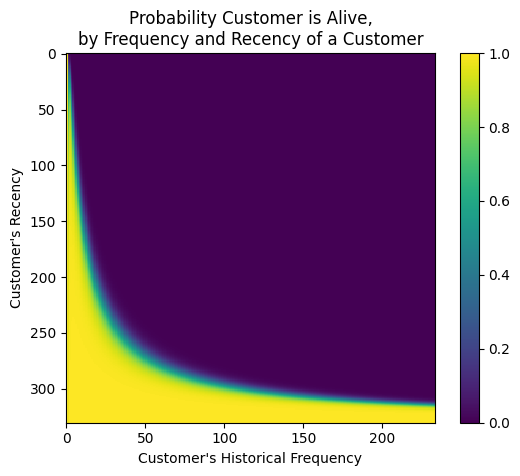

In [45]:
# Visualize the probability of a customer being active, considering frequency and recency values

plot_probability_alive_matrix(bgf, cmap='viridis')

### Gamma-Gamma Model

In [47]:
# Initialize and fit the Gamma-Gamma model for predicting monetary value per transaction

ggf = lf.GammaGammaFitter(penalizer_coef=0.1)

ggf.fit(probability_df['frequency'], probability_df['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2452 subjects, p: 0.86, q: 0.15, v: 0.84>

The results of the model tell us that most of the 2,452 customers fitted have consistent purchasing habits. Some customers spend significantly more than others, indicated by the lower 'q' value. 

Combining these findings for value with the purchase frequency results of the BG/NBD model will provide us greater insights.

In [49]:
probability_df['pred_average_sales'] = ggf.conditional_expected_average_profit(probability_df['frequency'], probability_df['monetary_value'])

In [50]:
probability_df

frequency  recency      T  monetary_value  prob_alive  \
CustomerID                                                          
cust1            29.0    274.0  280.0       72.337931    0.999817   
cust10            1.0     26.0  216.0      149.040000    0.656241   
cust100           7.0    266.0  325.0      114.755714    0.998030   
cust1000         47.0    280.0  282.0    23894.614681    0.999917   
cust1001         23.0    309.0  315.0       80.094348    0.999806   
...               ...      ...    ...             ...         ...   
cust995          12.0    207.0  260.0       64.314167    0.995943   
cust996          43.0    305.0  317.0     2094.251628    0.999658   
cust997          43.0    292.0  298.0       62.503488    0.999844   
cust998          77.0    232.0  235.0    23564.123506    0.999904   
cust999          25.0    304.0  324.0       78.353200    0.999433   

            prob_alive_365  pred_average_sales  
CustomerID                                      
cust1                  NaN           74.917114  
cust10                 NaN        11734.432113  
cust100                NaN          133.736321  
cust1000               NaN        24407.304085  
cust1001               NaN           83.724395  
...                    ...                 ...  
cust995                NaN           70.155455  
cust996                NaN         2143.482828  
cust997                NaN           63.992112  
cust998                NaN        23870.177214  
cust999                NaN           81.609321  

[2452 rows x 7 columns]

In [51]:
# Calculate the predicted CLV over the next 90 days using the BG/NBD model

probability_df['pred_clv_90d'] = ggf.customer_lifetime_value(
    bgf,
    probability_df['frequency'],
    probability_df['recency'],
    probability_df['T'],
    probability_df['monetary_value'],
    time=3,
    freq='D',
    discount_rate=0.01
)

In [52]:
# Calculate the predicted profit from each customer over the next 90 days

probability_df['pred_profit_90d'] = probability_df['pred_clv_90d'] * profit_margin

probability_df

frequency  recency      T  monetary_value  prob_alive  \
CustomerID                                                          
cust1            29.0    274.0  280.0       72.337931    0.999817   
cust10            1.0     26.0  216.0      149.040000    0.656241   
cust100           7.0    266.0  325.0      114.755714    0.998030   
cust1000         47.0    280.0  282.0    23894.614681    0.999917   
cust1001         23.0    309.0  315.0       80.094348    0.999806   
...               ...      ...    ...             ...         ...   
cust995          12.0    207.0  260.0       64.314167    0.995943   
cust996          43.0    305.0  317.0     2094.251628    0.999658   
cust997          43.0    292.0  298.0       62.503488    0.999844   
cust998          77.0    232.0  235.0    23564.123506    0.999904   
cust999          25.0    304.0  324.0       78.353200    0.999433   

            prob_alive_365  pred_average_sales   pred_clv_90d  pred_profit_90d  
CustomerID                                                                      
cust1                  NaN           74.917114     687.222443       123.700040  
cust10                 NaN        11734.432113    4546.846833       818.432430  
cust100                NaN          133.736321     267.827852        48.209013  
cust1000               NaN        24407.304085  358156.728138     64468.211065  
cust1001               NaN           83.724395     544.395167        97.991130  
...                    ...                 ...            ...              ...  
cust995                NaN           70.155455     291.831801        52.529724  
cust996                NaN         2143.482828   25650.010885      4617.001959  
cust997                NaN           63.992112     814.190468       146.554284  
cust998                NaN        23870.177214  684350.440077    123183.079214  
cust999                NaN           81.609321     559.824387       100.768390  

[2452 rows x 9 columns]

# Summary and Next Steps

### Model Results

Through a predictive modeling approach, we’ve found:

-	Churn-Based CLV: estimated expected revenue per customer of 2,155,335.77.
-	Lifetime-Based CLV: assumes a fixed customer lifespan value of 546,058.29.
-	These methods provide baseline CLV estimates and should not be used exclusively. Enhancing accuracy through added complexity within feature engineering is crucial for organizational use.

### Next Steps

While predictive modeling provides insights into customer behavior using historical data, it has limitations in making dynamic, scalable predictions. 

Machine learning models, such as XGBoost, improve prediction accuracy, capture hidden patterns, and create more dynamic, actionable forecasts. By running these models, we can provide higher-quality recommendations to stakeholders.